# Identify Fraud from Enron Email

## Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

In this project, I will play detective, and put my new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. This project has combined this data with a hand-generated list of persons of interest in the fraud case.

The goal of this project is to identify a person of interest. Which means an individual who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. POI identifier based on financial and email data made public as a result of the Enron scandal. Machine learning is an excellent tool for this kind of classification task as it can use patterns discovered from labeled data to infer the classes of new observations.

The dataset had significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. It could contain useful information for identifying POIs.
Insider Salary, Bonus, Long Term Incentive, Deferred Income, Total Payments, Exercised Stock Options, Total Stock Value and number of to/from emails messages are very usefull dataset information for the investigation. 


The features in the data fall into three major types, namely financial features, email features and POI labels.

A) financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

B) email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

C) POI label: [‘poi’] (boolean, represented as integer)

## 1. Data Exploration

In [1]:
### Required Modules and packages
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import matplotlib.pyplot
import pylab as pl
import numpy as np

from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from tester import dump_classifier_and_data
from sklearn.metrics import accuracy_score, precision_score, recall_score

sys.path.append("../tools/")


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
### Selected Features

financial_features = ['salary', 'deferral_payments', 'total_payments', \
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', \
'total_stock_value', 'expenses', 'exercised_stock_options', 'other', \
'long_term_incentive', 'restricted_stock', 'director_fees']

email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', \
'from_this_person_to_poi', 'shared_receipt_with_poi']

poi_label = ['poi']

features_list = poi_label + financial_features + email_features 


1.1 Load the dictionary containing the dataset and View the data

In [3]:
### Load the dictionary containing the dataset

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# data_dict
# data_dict['ALLEN PHILLIP K']

# Transform data from dictionary to the Pandas DataFrame
import pandas as pd
df = pd.DataFrame.from_dict(data_dict, orient = 'index')

df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [4]:
#len(df.notnull())

# Total number of data points 

print("Total Number of Data Points: %i" %len(data_dict))

Total Number of Data Points: 146


In [5]:
# Allocation across classes (POI/non-POI)

poi = 0
non_poi = 0

for person in data_dict:
    if data_dict[person]['poi'] == True:
       poi += 1
    else:
        non_poi += 1
print("Total Number of Person of Interest     : %i" % poi)
print("Total Number of Not Person of Interest : %i" % non_poi)


Total Number of Person of Interest     : 18
Total Number of Not Person of Interest : 128


In [6]:
# Number of features used
all_features = data_dict[data_dict.keys()[0]].keys()

len(all_features)

all_features, features_list

print("Total Number of Features used : %i" % len(features_list))


Total Number of Features used : 20


In [7]:
# print features_list

In [8]:
# Are there features with many missing values? etc.

missing_values = {}

for feature in all_features:
    missing_values[feature] = 0
    
for emp in data_dict:
    for feature in data_dict[emp]:
        if data_dict[emp][feature] == "NaN":
            missing_values[feature] += 1
            
print("The Number of Missing values for each Feature: ")

for feature in missing_values:
    print("%s: %i" %(feature, missing_values[feature]))
    

The Number of Missing values for each Feature: 
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
email_address: 35
restricted_stock_deferred: 128
total_stock_value: 20
shared_receipt_with_poi: 60
long_term_incentive: 80
exercised_stock_options: 44
from_messages: 60
other: 53
from_poi_to_this_person: 60
from_this_person_to_poi: 60
poi: 0
deferred_income: 97
expenses: 51
restricted_stock: 36
director_fees: 129


1.2 From the Data exploration, There are 146 data points and each with 20 features and a binary classification ("poi")

1.3 In the 146 data points:

Total Number of Person of Interest     : 18

Total Number of Not Person of Interest : 128

1.4 The Number of Missing values for each Feature: 
salary: 51

to_messages: 60

deferral_payments: 107

total_payments: 21

loan_advances: 142

bonus: 64

email_address: 35

restricted_stock_deferred: 128

total_stock_value: 20

shared_receipt_with_poi: 60

long_term_incentive: 80

exercised_stock_options: 44

from_messages: 60

other: 53

from_poi_to_this_person: 60

from_this_person_to_poi: 60

poi: 0

deferred_income: 97

expenses: 51

restricted_stock: 36

director_fees: 129

## 2. Outliers 

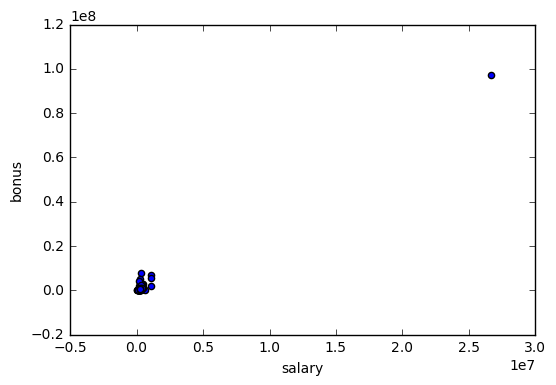

In [9]:
### Task 2: Find out the Outliers and Remove the outliers
from feature_format import featureFormat, targetFeatureSplit
### Identify Outliers by ploting
## 1.
features = ["salary", "bonus"]

data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus  = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()


2.1 During the initial analysis of the data and by plotting features such as Salaries vs Bonuses, I was able to identify that there was one significant outlier. By using the plot and the original dataset PDF in final_project/enron61702insiderpay.pdf, I able to identify that the outlier is "Total". The dictionary key is "TOTAL". It is a spreadsheet quirk. Lets remove and replot.

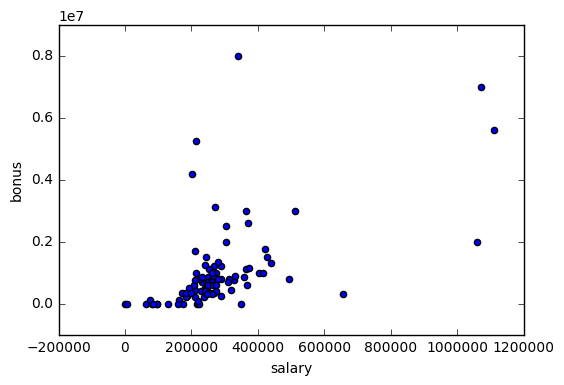

In [11]:
# Remove this outlier

data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()


2.2 Look for more outliers to investigate; I am looking the following features according to my intution.

a) 'total_payments', 'total_stock_value' , 'from_poi_to_this_person', 'from_this_person_to_poi'

b) People made bonuses of at least 5 million dollars, and a salary of over 1 million dollars; in other words, they made out like bandits. What are the names associated with those points?


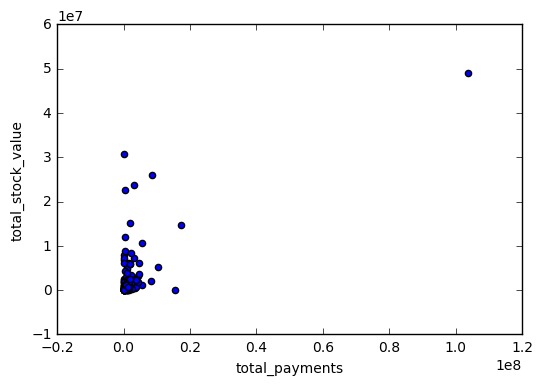

None


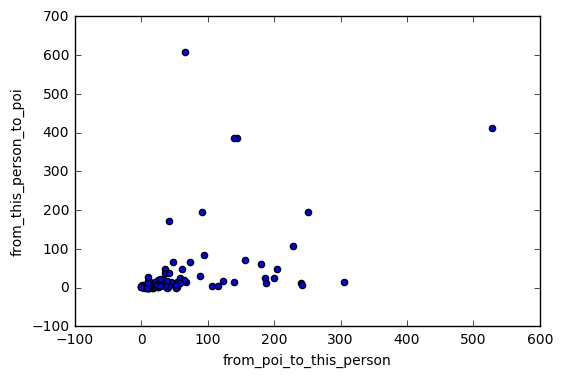

None


In [12]:
import matplotlib.pyplot
def Outliers(data_set, feature_x, feature_y):
    
    data = featureFormat(data_set, [feature_x, feature_y])
    for point in data:
        x = point[0]
        y = point[1]
        matplotlib.pyplot.scatter( x, y )
    matplotlib.pyplot.xlabel(feature_x)
    matplotlib.pyplot.ylabel(feature_y)
    matplotlib.pyplot.show()
    
print(Outliers(data_dict, 'total_payments', 'total_stock_value'))

print(Outliers(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))


In [13]:
# Two people made bonuses of at least 5 million dollars, and a salary of over 1 million dollars; in other words, they made out like bandits.
# What are the names associated with those points?

for employee in data_dict:
    if (data_dict[employee]["salary"] != 'NaN') and (data_dict[employee]["bonus"] != 'NaN'):
        if float(data_dict[employee]["salary"]) >1000000 and float(data_dict[employee]["bonus"])>5000000:
            print employee
            

LAY KENNETH L
SKILLING JEFFREY K


In [14]:
# More outliers to investigate

for employee in data_dict:
    if (data_dict[employee]["total_payments"] != 'NaN') and (data_dict[employee]["total_stock_value"] != 'NaN'):
        if float(data_dict[employee]["total_payments"]) > 1000000 and float(data_dict[employee]["total_stock_value"])> 4500000:
            print employee

BAXTER JOHN C
HORTON STANLEY C
WALLS JR ROBERT H
LAVORATO JOHN J
WHALLEY LAWRENCE G
LAY KENNETH L
SKILLING JEFFREY K
KEAN STEVEN J
WHITE JR THOMAS E
DIMICHELE RICHARD G
FREVERT MARK A
PAI LOU L
IZZO LAWRENCE L


In [15]:
# # More outliers from email to and from

for employee in data_dict:
    if (data_dict[employee]["from_poi_to_this_person"] != 'NaN') and (data_dict[employee]["from_this_person_to_poi"] != 'NaN'):
        if float(data_dict[employee]["from_poi_to_this_person"]) > 400 and float(data_dict[employee]["from_this_person_to_poi"])> 350:
            print employee

LAVORATO JOHN J


In [16]:
# These outliers belong to our person of interest.

outliers = []
for key in data_dict:
    value = data_dict[key]['salary']
    if value == 'NaN':
        continue
    outliers.append((key, int(value)))

top_outliers = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
print "The top 4 salary outliers are :\n"
print top_outliers

The top 4 salary outliers are :

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


In [17]:
outliers = []
for key in data_dict:
    value = data_dict[key]['total_payments']
    if value == 'NaN':
        continue
    outliers.append((key, int(value)))

top_outliers = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
print "The top 4 total_payments outliers are :\n"
print top_outliers

The top 4 total_payments outliers are :

[('LAY KENNETH L', 103559793), ('FREVERT MARK A', 17252530), ('BHATNAGAR SANJAY', 15456290), ('LAVORATO JOHN J', 10425757)]


2.3 From the above analysis. I found dcionary key "TOTAL" which is a spreadsheet quirk. Also following POIs "LAY KENNETH L",
"SKILLING JEFFREY K" , "LAVORATO JOHN J" and some are making total payment over 1 million dollars, and a total stock value over 4.5 million dollars. But those outlier data points are valid and required for my investigation.


In [18]:
# Find number of "NaN" in the Financial Features
NaN_dict = {}

for person in data_dict:
    NaN_dict[person] = 0
    for feature in financial_features:
        if data_dict[person][feature] == "NaN":
            NaN_dict[person] += 1
            
sorted(NaN_dict.items(), key=lambda x: x[1])

[('HAEDICKE MARK E', 2),
 ('DETMERING TIMOTHY J', 2),
 ('LAY KENNETH L', 2),
 ('ALLEN PHILLIP K', 2),
 ('REYNOLDS LAWRENCE', 2),
 ('FREVERT MARK A', 2),
 ('BAXTER JOHN C', 3),
 ('PIPER GREGORY F', 3),
 ('DERRICK JR. JAMES V', 3),
 ('HANNON KEVIN P', 4),
 ('MULLER MARK S', 4),
 ('RIEKER PAULA H', 4),
 ('LINDHOLM TOD A', 4),
 ('OLSON CINDY K', 4),
 ('GAHN ROBERT S', 4),
 ('HERMANN ROBERT J', 4),
 ('BELDEN TIMOTHY N', 4),
 ('RICE KENNETH D', 4),
 ('WASAFF GEORGE', 4),
 ('SHARP VICTORIA T', 4),
 ('BAY FRANKLIN R', 4),
 ('BUY RICHARD B', 4),
 ('ELLIOTT STEVEN', 5),
 ('MCMAHON JEFFREY', 5),
 ('BLACHMAN JEREMY M', 5),
 ('COLWELL WESLEY', 5),
 ('WALLS JR ROBERT H', 5),
 ('SHANKMAN JEFFREY A', 5),
 ('BERGSIEKER RICHARD P', 5),
 ('BIBI PHILIPPE A', 5),
 ('ECHOLS JOHN B', 5),
 ('LAVORATO JOHN J', 5),
 ('BANNANTINE JAMES M', 5),
 ('SHELBY REX', 5),
 ('DEFFNER JOSEPH M', 5),
 ('WHALLEY LAWRENCE G', 5),
 ('MCCONNELL MICHAEL S', 5),
 ('DELAINEY DAVID W', 5),
 ('BUTTS ROBERT H', 5),
 ('FALLON JAMES B'

In [19]:
data_dict["LOCKHART EUGENE E"], data_dict["THE TRAVEL AGENCY IN THE PARK"]

({'bonus': 'NaN',
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 'NaN',
  'expenses': 'NaN',
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN',
  'poi': False,
  'restricted_stock': 'NaN',
  'restricted_stock_deferred': 'NaN',
  'salary': 'NaN',
  'shared_receipt_with_poi': 'NaN',
  'to_messages': 'NaN',
  'total_payments': 'NaN',
  'total_stock_value': 'NaN'},
 {'bonus': 'NaN',
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 'NaN',
  'expenses': 'NaN',
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 362096,
  'poi': False,
  'restricted_stock': 'NaN',
  'restricted_st

2.4 Remove Outliers - Found out that the couple of data points, all of the feature are "NaN" in the Financial Features. I am going to drop those also with "TOTAL".

In [20]:
# Drop the outliers
for key in ["TOTAL", "THE TRAVEL AGENCY IN THE PARK", "LOCKHART EUGENE E"]:
    data_dict.pop(key, 0)

#data_dict["LOCKHART EUGENE E"], data_dict["THE TRAVEL AGENCY IN THE PARK"], data_dict["TOTAL"]

## 3. Feature Selection / Engineering Features

First,I go through the features and use my intution to see any pattern in the features, also by doing visualization techniques and code up find any usefull festures. I try to ignore the feature if it is noisy, if it causes overfitting and strongly related with a feature thats's allready present. Does the feature giving descriminating power between poi and non poi, use human intution what feature might contain usefull information. I select the feature with bear minimun number of features that give much infromation as possible. If feature give not much information, I try to ignore those.


#### 3.1 Selecting and Creating New Features

Mainly emails from each employees should take into consideration, including tens of thousands of emails and it should had detailed financial data for top executives. It could contain useful information for identifying POIs. Insider Salary, Bonus, Long Term Incentive, Deferred Income, Total Payments, Exercised Stock Options, Total Stock Value and number of to/from emails messages are very usefull dataset information for the investigation.

I select those features in my data that contribute most to the prediction output in which I am interested. Having irrelevant features in the data can decrease the accuracy of models. Selected those to reduce Overfitting and also considered reduce Training Time.

In our dataset we’ve got the number of emails sent to POI’s and received from POI’s for most of the employees. However, if an employee sends or receives a lot of emails in general, it is likely that the quantity of them sent or received from POI’s would be large as well. This is why we are creating these two new features: - fraction of ‘to_messages’ received from a POI; - fraction of ‘from_messages’ sent to a POI.

When I engineered a feature that identified when a given person was on the same email as a POI. So for example, if Ken Lay and Katie Malone are both recipients of the same email message, then Katie Malone should have her "shared receipt" feature incremented. If she shares lots of emails with POIs, maybe she's a POI herself. Ken Lay always shares receipt with a POI, because he is a POI. So the "shared receipt" feature became extremely powerful in finding POIs, because it effectively was encoding the label for each person as a feature. But it may introduce a bug too.


In [21]:
### Task 3: Create new feature(s)
### New Feature Selection

### Store to my_dataset for easy export below.

my_dataset = data_dict

def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
### Returns either the fraction of all messages to this person that come from POIs 
### or the fraction of all messages from this person that are sent to POIs
### beware of "NaN" when there is no known email address (and so
### no filled email features), and integer division!
### in case of poi_messages or all_messages having "NaN" value, return 0.

    fraction = 0.
    
    if all_messages == 'NaN':
        return fraction
    
    if poi_messages == 'Nan':
        poi_messages
    
    fraction = float((poi_messages) / float(all_messages))
    
    return fraction

for name in my_dataset:

    data_point = my_dataset[name]

    print
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    print fraction_from_poi
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    print fraction_to_poi
    data_point["fraction_to_poi"] = fraction_to_poi

#features_list

new_features_list =  features_list + ['fraction_from_poi', 'fraction_to_poi']

print new_features_list

#new_features_list


0.0470879801735
0.0344827586207

0.0
0.0

0.0
0.0

0.0130890052356
0.0

0.0306220095694
0.65625

0.0
0.0

0.0
0.0

0.0246284501062
0.541666666667

0.0187234042553
0.0139794967381

0.0492730210016
0.216216216216

0.078125
1.0

0.108108108108
0.0

0.010101010101
0.142857142857

0.013978088402
0.342105263158

0.0
0.0

0.0
0.0

0.136518771331
0.275

0.0882352941176
0.0

0.0968992248062
0.339285714286

0.0
0.0

0.0
0.0

0.0253353204173
0.0

0.0302227573751
0.112268518519

0.0
0.0

0.0
0.0

0.0291834833903
0.0309585975382

0.0
0.0

0.0104438642298
0.0

0.0
0.0

0.014312383323
0.2

0.0263554216867
0.585365853659

0.0
0.0

0.0196855775803
0.0888786553074

0.00698080279232
0.368421052632

0.0
0.0

0.0
0.0

0.030303030303
0.037037037037

0.0
0.0

0.0105042016807
0.0

0.031746031746
0.0

0.0174459176553
0.0093023255814

0.0
0.0

0.0237420269313
0.222222222222

0.072737291638
0.158994197292

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0689045936396
0.0

0.0
0.0

0.00488481087861
0.053497942386

#### 3.2 Selecting Best Features

For an algorithm that supports getting the feature importances - decision tree or feature scores SelectKBest.

There are several methods of automatically selecting features in sklearn. Many of them fall under the umbrella of univariate feature selection, which treats each feature independently and asks how much power it gives in classifying or regressing.

There are two big univariate feature selection tools in sklearn: SelectPercentile and SelectKBest.

1. SelectPercentile selects the X% of features that are most powerful (where X is a parameter)

2. SelectKBest selects the K features that are most powerful (where K is a parameter).

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method.

In [22]:
### Extract features and labels from dataset for local testing

data = featureFormat(my_dataset, new_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)
selector.fit_transform(features, labels)
scores = zip(new_features_list[1:],selector.scores_)
sorted_scores = sorted(scores, key = lambda x: x[1], reverse=True)
print sorted_scores

KBest_features = poi_label + list(map(lambda x: x[0], sorted_scores))[0:10]
print("KBest_features:") 

print KBest_features

[('exercised_stock_options', 24.815079733218194), ('total_stock_value', 24.182898678566879), ('bonus', 20.792252047181535), ('salary', 18.289684043404513), ('fraction_to_poi', 16.409712548035792), ('deferred_income', 11.458476579280369), ('long_term_incentive', 9.9221860131898225), ('restricted_stock', 9.2128106219771002), ('total_payments', 8.7727777300916756), ('shared_receipt_with_poi', 8.589420731682381), ('loan_advances', 7.1840556582887247), ('expenses', 6.0941733106389453), ('from_poi_to_this_person', 5.2434497133749582), ('other', 4.1874775069953749), ('fraction_from_poi', 3.1280917481567192), ('from_this_person_to_poi', 2.3826121082276739), ('director_fees', 2.1263278020077054), ('to_messages', 1.6463411294420076), ('deferral_payments', 0.22461127473600989), ('from_messages', 0.16970094762175533), ('restricted_stock_deferred', 0.065499652909942141)]
KBest_features:
['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 

I deployed Univariate feature algorithm "SelectKBest". 

The sklearn.feature_selection module SelectKBest with f_classif parameter used for feature selection to reduce the features on sets. The features are selected  according to the k highest scores. In the total set of features, only the 11 ones are significant. Those features are added to the feature list to be the best features for the analysis.

KBest_features:
['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'long_term_incentive', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi']

In [23]:
# Replacing 'NaN' with "0" in data_dict
for emp in data_dict:
    for f in data_dict[emp]:
        if data_dict[emp][f] == 'NaN':
            # fill NaN values
            data_dict[emp][f] = 0

In [24]:
# Store to my_dataset again after replace the "NaN" on data_dict 
my_dataset = data_dict

# But SelectKBest also selected "fraction_to_poi". Which is in the "KBest_features".
# Remove this one to have the initial features in the list.

KBest_features.remove("fraction_to_poi")

#### 3.3 Feature Scaling

In [25]:
# Feature scaling - using MinMaxScaler
# Apply MinMaxScaler to obtain the new scaled features:

### 1. Dataset without new features 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn import preprocessing

data = featureFormat(my_dataset, KBest_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)


1. What features did you end up using in your POI identifier?
The two features I created are: 

    1."fraction_from_poi"

    2. "fraction_to_poi"

"fraction_from_poi" - Which represents the ratio of the messages from POI to this person against all the messages sent to this person

"fraction_to_poi" - Which represents the ratio from this person to POI against all messages from this person.

2. What selection process did you use to pick them? I am using one of the univariate feature selection tools in sklearn. Which is "SelectKBest". 

3. Did you have to do any scaling? Yes, I applied "MinMaxScaler".

Why or why not? 

1. New features - In our dataset we’ve got the number of emails sent to POI’s and received from POI’s for most of the employees. However, if an employee sends or receives a lot of emails in general, it is likely that the quantity of them sent or received from POI’s would be large as well. This is why we are creating these two new features: - fraction of ‘to_messages’ received from a POI; - fraction of ‘from_messages’ sent to a POI.

When I engineered a feature that identified when a given person was on the same email as a POI. So for example, if Ken Lay and Katie Malone are both recipients of the same email message, then Katie Malone should have her "shared receipt" feature incremented. If she shares lots of emails with POIs, maybe she's a POI herself. Ken Lay always shares receipt with a POI, because he is a POI. So the "shared receipt" feature became extremely powerful in finding POIs, because it effectively was encoding the label for each person as a feature. But it may introduce a bug too. 

2. Univeriate algorithm "SelectKBest" - Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model. "SelectKBest" removes all but the k highest scoring features.

3. MinMax Scaler - It Transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one. What if x_max and x_min are the same? For example, suppose the list of input features is [10, 10, 10]--the denominator will be zero. This exact formula can be broken. If you look at finance_features, there are some "NaN" values that have been cleaned away and replaced with zeroes. While those might look like the minima, it's a bit deceptive because they're more like points for which we don't have information, and just have to put in a number. 

Here, I appled MinMaxScaler to obtain the new scaled features. Mainly SVM, K-nearest neighbors, PCA and logistic regression require features to be normalized. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. Beside the DecisionTree Classifier and Naive Bayes classifiers do not give any changes using the MinMax feature scaling. 

If I wanted 'from_messages' and 'salary' as feature for clustering, then feature scaling would be critical on using SVM and K-nearest neighbors algorithms. They really depend on feature scaling. 

MinMaxScaler feature scaling is used on SVM and Logistic Regression to compare the prediction accuracies with Decession Tree and Naive Bayes.  


In [26]:
### 2. Dataset with new features - New features created from email_features
feature_1 = "fraction_from_poi"
feature_2 = "fraction_to_poi"

N_KBest_features = KBest_features + [feature_1, feature_2]
 
data = featureFormat(my_dataset, N_KBest_features, sort_keys = True)
N_labels, N_features = targetFeatureSplit(data)
N_features = scaler.fit_transform(N_features)

#print N_features

### 4.  Choosing an Algorithm

I am going to try varity of following Classifiers. 

1. Naive Bayes GaussianNB
2. DecisionTreeClassifier
3. Support Vecctor Machines
4. Linear Model Logistic Regression

In statistics and machine learning we usually split our data into to subsets: training data and testing data and fit our model  on the train data. In order to make predictions on the test data. When we do that, one of two thing might happen: we overfit our model or we underfit our model. We don’t want any of these things to happen, because they affect the predictability of our model. In order to avoid this, we can perform something called cross validation. It’s very similar to train/test split, but it’s applied to more subsets. Meaning, we split our data into k subsets, and train on k-1 one of those subset. 

In scikit-learn a random split into training and test sets can be quickly computed with the "train_test_split" helper function. 
We can now quickly sample a training set while holding out 30% of the data for testing (evaluating) our classifier.

In [27]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = \
     cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
       

In [28]:
# 4.1 Naive Bayes

from sklearn.naive_bayes import GaussianNB

### create classifier
clf = GaussianNB()

### fit the classifier on the training features and labels
clf.fit(features_train, labels_train)

### use the trained classifier to predict labels for the test features
pred = clf.predict(features_test)

### Estimate the accuracy
accuracy = clf.score(features_test, labels_test)
print "Naive Bayes Accuracy: ", accuracy

Naive Bayes Accuracy:  0.883720930233


In [29]:
# 4.1.1 Naive Bayes with New Features 

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = \
     cross_validation.train_test_split(N_features, N_labels, test_size=0.3, random_state=42)
    
from sklearn.naive_bayes import GaussianNB

### create classifier
clfN = GaussianNB()

### fit the classifier on the training features and labels
clfN.fit(features_train, labels_train)

### use the trained classifier to predict labels for the test features
predN = clfN.predict(features_test)

### Estimate the accuracy
accN = clfN.score(features_test, labels_test)
print accN

0.883720930233


In [29]:
# 4.2 DecisionTreeClassifier
#from sklearn import tree

clf_DT = tree.DecisionTreeClassifier()

clf_DT.fit(features_train, labels_train)

pred = clf_DT.predict(features_test, labels_test)

accDT = accuracy_score(pred, labels_test)

print "DecisionTree Classifier Accuracy: ", accDT


DecisionTree Classifier Accuracy:  0.837209302326


In [30]:
# 4.3 SVM - Support Vector Machines
#from sklearn.svm import SVC

clfSVM = SVC(kernel= "rbf" , C = 1.0)  

clfSVM.fit(features_train, labels_train)

pred = clfSVM.predict(features_test)

accSVM = accuracy_score(pred, labels_test)

print "Support Vector Machines Accuracy: ", accSVM


Support Vector Machines Accuracy:  0.883720930233


In [31]:
# 4.4 Linear Model Logistic Regression
#from sklearn.linear_model import LogisticRegression

clfReg = LogisticRegression(C=1e5)

clfReg.fit(features_train, labels_train)

pred = clfReg.predict(features_test)

accReg = accuracy_score(labels_test, pred)

print " Logistic Regression Accuracy: ", accReg


 Logistic Regression Accuracy:  0.837209302326


#### 5. Validation and Parameter Tuning

Cross Validation With Parameter Tuning Using Grid Search: Given a grid_search and parameters list for a specific model, along with features and labels list. It tunes the algorithm using grid search and prints out the average evaluation metrics results such as accuracy, percision, recall after performing the tuning for iter times, and the best hyperparameters for the model.
The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.


In [30]:
from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score

def tune_params(grid_search, features, labels, params, iters = 80):
    acc = []
    pre = []
    recall = []
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.3, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)

        acc = acc + [accuracy_score(labels_test, predicts)] 
        pre = pre + [precision_score(labels_test, predicts)]
        recall = recall + [recall_score(labels_test, predicts)]
    print "accuracy  : {}".format(np.mean(acc))
    print "precision : {}".format(np.mean(pre))
    print "recall    : {}".format(np.mean(recall))

    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print("%s = %r, " % (param_name, best_params[param_name]))


##### 5.1 Naive Bayes GaussianNB
sklearn.naive_bayes.GaussianNB

class sklearn.naive_bayes.GaussianNB(priors=None)

In [31]:
from sklearn.naive_bayes import GaussianNB
NB_clf = GaussianNB()
NB_param = {}
NB_grid_search = GridSearchCV(estimator = NB_clf, param_grid = NB_param)
print("Naive Bayes Model Evaluation: ")

#tune_params(NB_grid_search, features, labels, NB_param)
#tune_params(NB_grid_search, N_features, N_labels, NB_param)

Naive Bayes Model Evaluation: 


##### 5.2 sklearn.tree.DecisionTreeClassifier

class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)

criterion - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

In [32]:
from sklearn import tree
DT_clf = tree.DecisionTreeClassifier()
DT_param = {'criterion':("gini", "entropy"),'splitter':("best","random")}
DT_grid_search = GridSearchCV(estimator = DT_clf, param_grid = DT_param)
print("Decision Tree Model Evaluation: ")

#tune_params(DT_grid_search, features, labels, DT_param)
#tune_params(DT_grid_search, N_features, N_labels, DT_param)

Decision Tree Model Evaluation: 


##### 5.3 Support Vector Machines SVC

sklearn.svm.SVC

Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used.

class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

In [33]:
from sklearn import svm
SVM_clf = svm.SVC()
SVM_param = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C': [0.1, 1, 10, 100, 1000]}
SVM_grid_search = GridSearchCV(estimator = SVM_clf, param_grid = SVM_param)
print("SVM Model Evaluation: ")

#tune_params(SVM_grid_search, features, labels, SVM_param)
#tune_params(SVM_grid_search, N_features, N_labels, SVM_param)


SVM Model Evaluation: 


##### 5.4 Linear Model Logistic Regression

sklearn.linear_model.LogisticRegression

class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)

C: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

tol : float, default: 1e-4 Tolerance for stopping criteria.

In [34]:
from sklearn.linear_model import LogisticRegression
LoR_clf = LogisticRegression()
LoR_param = {'tol': [1, 0.1, 0.01, 0.001, 0.0001],
'C': [0.1, 0.01, 0.001, 0.0001]}
LoR_grid_search = GridSearchCV(estimator = LoR_clf, param_grid = LoR_param)
print("Logistic Regression model evaluation: ")

#tune_params(LoR_grid_search, features, labels, LoR_param)
#tune_params(LoR_grid_search, N_features, N_labels, LoR_param)

Logistic Regression model evaluation: 


### 6. Validate and Evaluate 

I tried 4 algorithms and selected Naive Bayes GaussianNB. Naive Bayes GaussianNB classifier predicted the accuracy 84%. Compare to others I preferred GaussianNB.

 Accuracy = No of items in a class labeled correctly / All items in that class = 0.84

Here we used GridSearchCV, It is a way of systematically working through multiple combinations of parameter tunes, cross- validating as it goes to determine which tune gives the best performance. After performing the tuning for iter times, the average evaluation metrics results such as accuracy, percision, recall predicted the best hyperparameters for the model.

1.What validation is in the context of machine learning projects, why validation is important. A classic mistake in a validation process.

In machine learning, model validation is referred to as the process where a trained model is evaluated with a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test the generalization ability of a trained model. Model validation aims to find an optimal model with the best performance.

Valation is an very important step in machine learning project, because it can test the generalisation power (ie. predict power) of the model on the unseen dataset (ie. the test dataset or the validate dataset). So a classic mistake would be using the information of the validate dataset in the training process, this may lead to overfitting on the dataset.

2.Metrics used to evaluate algorithm performance.

 Recall: True Positive / (True Positive + False Negative)  - Out of all the items that are truly positive, how many were correctly classified as positive.
        
 Precision: True Positive / (True Positive + False Positive) - Out of all the items labeled as positive, how many truly belong to the positive class.    

In the context to this project: The Precision Score is when the algorithm predicts that somebody is a POI. Which measures how certain we are that the person really is a POI. The Recall Score measures the ratio of the POIs that the algorithm correctly picked out from all the POIs.

True Positive is a POI who is identified correctly as a POI and a False Negative is a POI who was not idenitifed correctly. In this classification, I was able to produce a Precision: 0.36639	and Recall: 0.31400. That means, 31%  of the POIs that the algorithm correctly picked out from all the POIs.

Precision: 0.36639
Recall: 0.31400

Generally, we want to build a model whihch has higher ratios for both “Precision Score” and “Recall Score”, but unfortunately in most cases we have to trade off between these two metrics. So in order to evaluate the model using just one metric, we can use the harmonic mean of the “Precision Score” and “Recall Score” which is called “F1 Score”.

The measures that are a combination of Precision and Recall are the F-measure

F = 2 * ((Precision * Recall)/(Precision + Recall))

This measure usually referred to as F1 score, it is the average of Precision and Recall when they are close. This is the harmonic mean.
F1: 0.33818

3.Performance of the final algorithm selected is assessed by splitting the data into training and testing sets or through the use of cross validation.

Below, I used StratifiedShuffleSplit Cross validation method. A technique for testing how well a model generalizes in the absence of a holdout test sample. Cross-validation divides the training data into a number of subsets, and then builds the same number of models, with each subset held out in turn. Each of those models is tested on the holdout sample, and the average accuracy of the models on those holdout samples is used to estimate the accuracy of the model when applied to new data. 

Here, training and testing data are created using StratifiedShuffleSplit, which shuffled the data and split into K different set, called folds. In this dataset, I split the data into 1000 folds.


In [35]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.cross_validation import StratifiedShuffleSplit
#from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

# Example starting point. Try investigating other evaluation techniques!

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

#### Selected algorithm GaussianNB
clf = NB_clf

features_list = KBest_features

test_classifier(clf, my_dataset, features_list)

GaussianNB()
	Accuracy: 0.83613	Precision: 0.36639	Recall: 0.31400	F1: 0.33818	F2: 0.32324
	Total predictions: 15000	True positives:  628	False positives: 1086	False negatives: 1372	True negatives: 11914



In [36]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

References:

http://scikit-learn.org/stable/

http://scikit-learn.org/stable/tutorial/index.html

https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

https://towardsdatascience.com/machine-learning/home 
